In [1]:
#----------------------------------------------
# Stefano Piacentini - 05/02/2020
#----------------------------------------------

library(rjags)

# initial phase taken from dama's paper
phi_0 = 3.658

results = NULL
results$A_mean = 0     
results$A_sd   = 0
results$B_mean = 0     
results$B_sd   = 0
results$chi2_C = 0
results$chi2_S = 0
results$LR_CS  = 0     
results$OC_CS  = 0
results$BF_CS  = 0 
results$dof    = 0




Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs



In [2]:
# Definition of saewtooth function
rate_sim = function(x, rx, 
                    A = 0.,
                    v = 1.,
                    phi = 0. * pi,
                    B = 0.,
                    SAW = 0) {
    
#    N_windows <- nrow(timewindows)
#    
#    timewindows_norm <- timewindows / 365
#    center <- (timewindows_norm[2] - timewindows_norm[1] )/ 2 + timewindows_norm[1]
    
#    ret <- 0
#    
#    for (i in 1:N_windows) {
#        if (x > timewindows_norm[i,1] && x < timewindows_norm[i,2]) {
#            x_0 <- center[i,1]
            ret <- A * cos(2 * pi * x / v + phi) + SAW * B * ( rx )
#            break
#        }
#    }
    return(ret)
} 

In [3]:
# Definition of the function return the right rescaled time
resc_t = function(x, timewindows) {
    
    N_windows <- nrow(timewindows)
    
    timewindows_norm <- timewindows / 365
    center <- (timewindows_norm[2] - timewindows_norm[1] )/ 2 + timewindows_norm[1]
    
    ret <- 0
    
    for (i in 1:N_windows) {
        if (x > timewindows_norm[i,1] && x < timewindows_norm[i,2]) {
#            print(x)
            x_0 <- center[i,1]
#            print(x_0)
            ret <- (x-x_0)
            break
        }
    }
    return(ret)
} 

In [4]:
# Loading time windows
timewindows <- read.table("timewindows.txt")

In [5]:
#rate_sim = function(x,
#                    A = 0.,
#                    v = 1.,
#                    phi = 0. * pi,
#                    B = 0.01,
#                    SAW = 0) {
#    ret <- A * cos(2 * pi * x / v + phi) -SAW * (B*v)/2. + SAW *B * ((x+0.15) %%v)
#    return(ret)
#}

In [46]:
dataframe <- read.table("dama_1.txt")

yp  <- read.csv("DAMA_data/data_NaI_2_6_y+.csv", header = FALSE)


N_r <- nrow(dataframe)
t_real <- rep(1, N_r)
ren_t  <- rep(1, N_r)
x_real <- rep(1, N_r)
sd_real <- rep(1, N_r)

for (i in 1:N_r) {
    t_real[i] <- dataframe[i, 1]
    x_real[i] <- dataframe[i, 2]
    
    # dev std media a occhio dai plot
    if (t_real[i] <= 3000) {
        sd_real[i] <- 0.030/2
    } else if (t_real[i]< 5800 && t_real[i] > 3000) {
        sd_real[i] <- 0.015/2
    } else if (t_real[i]>= 5800) {
        sd_real[i] <- 0.009/2/0.8
    }
        sd_real[i] <- yp[i,2] - dataframe[i,2]


}
ren_t <- (t_real)/365

#rescaled time

time_resc <- rep(0, length(ren_t))
for(i in 1:length(time_resc)) {
    time_resc[i] <- resc_t(ren_t[i], timewindows)
}

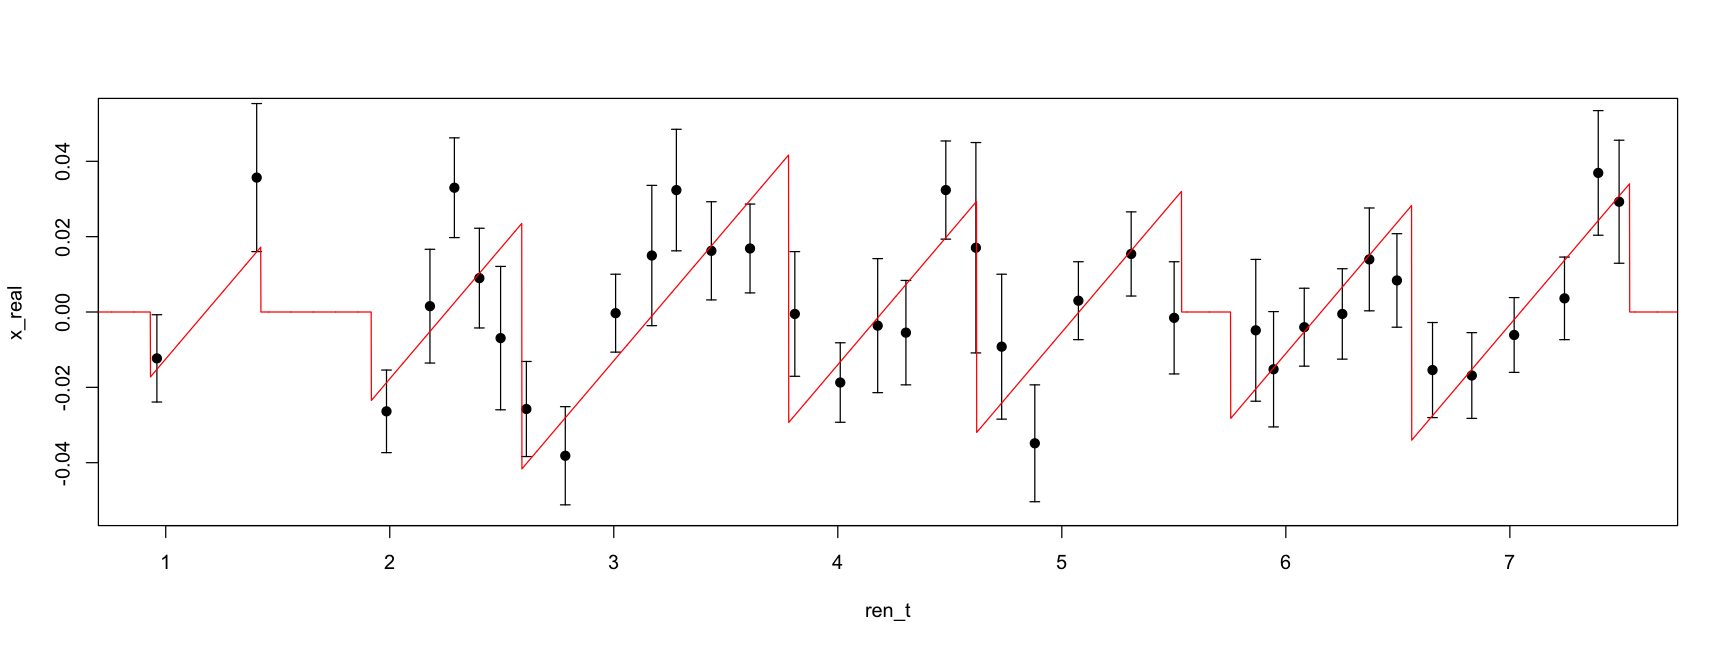

In [47]:
options(repr.plot.width=8*1.8, repr.plot.height=3*1.8)

plot(ren_t, x_real,
    pch=19, ylim = c(-1.5 * 0.035 , 1.5 * 0.035)
)
arrows(ren_t, x_real-sd_real, ren_t, x_real+sd_real, length=0.04, angle=90, code=3)

tmp <- seq(0., 8., by = 1e-3)
vec <- seq(0., 8., by = 1e-3)

for (i in 1:length(tmp)) {
    vec[i] <- resc_t(tmp[i], timewindows)  
}

# Just an example (NOT THE FIT)
vec <- rate_sim(x = tmp, rx= vec, SAW = 1,
                    A   = 0.,
                    phi = 0.0,
                    B   = 0.07,
                   )

lines(tmp, vec, col = 'red')

Warning message in jags.model(modello_cos, fitInput_r_cos, model_cos_init):
“Unused variable "ft" in data”
Warning message in jags.model(modello_cos, fitInput_r_cos, model_cos_init):
“Unused variable "a" in data”
Warning message in jags.model(modello_cos, fitInput_r_cos, model_cos_init):
“Unused variable "max_A" in data”
Warning message in jags.model(modello_cos, fitInput_r_cos, model_cos_init):
“Unused variable "max_phi" in data”
Warning message in jags.model(modello_cos, fitInput_r_cos, model_cos_init):
“Unused variable "width_B" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 37
   Unobserved stochastic nodes: 1
   Total graph size: 373

Initializing model


Iterations = 11001:21000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     1.671e-02      2.891e-03      2.891e-05      3.662e-05 

2. Quantiles for each variable:

   2.5%     25%     50%     75%   97.5% 
0.01109 0.01478 0.01670 0.01865 0.02240 



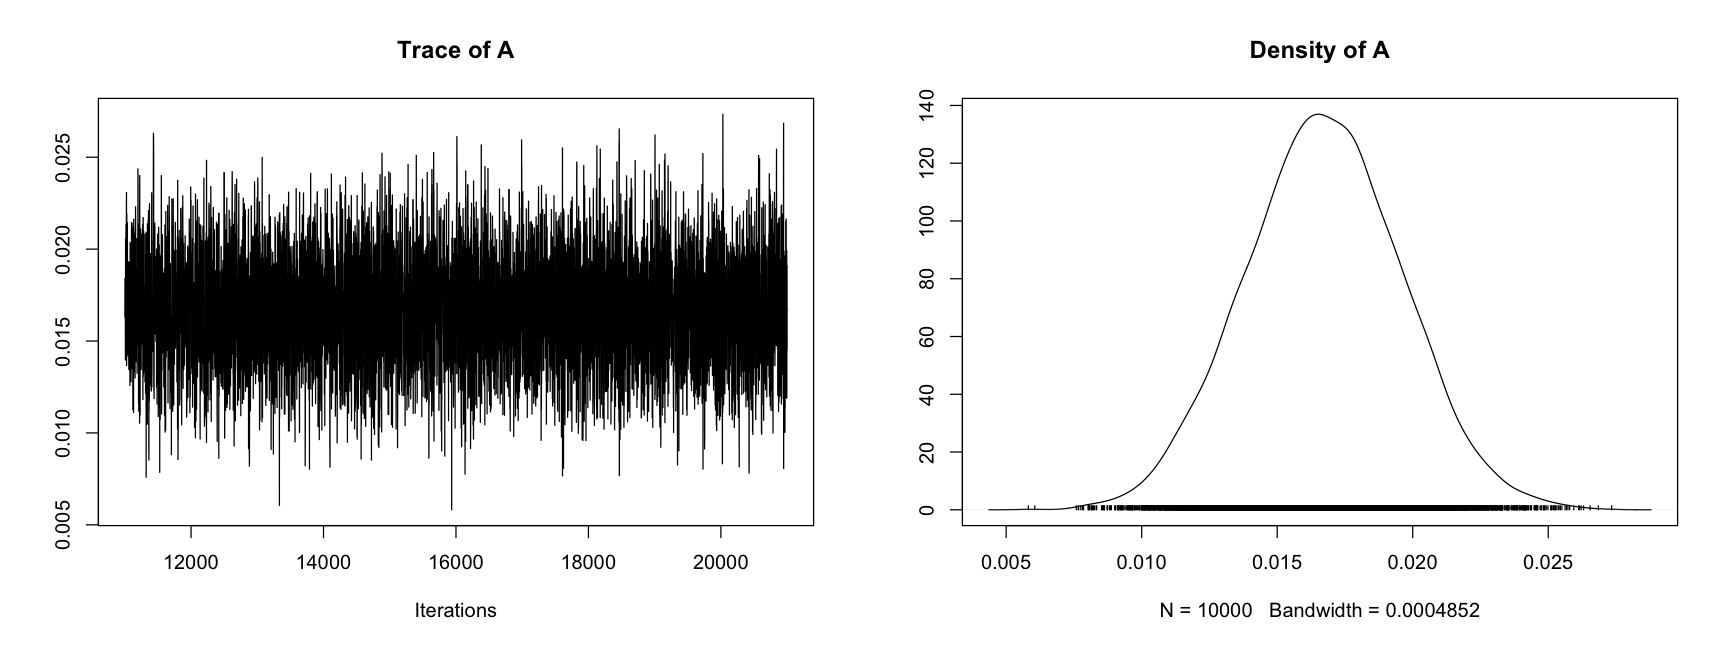

In [48]:
# FIT OF THE REAL DATA WITH COS


# Setting parameters for unif. priors
max_Acos     <- 0.012
max_Bcos     <- 0.03
sc_A         <- 0.05
max_phicos   <- 2 * pi
a            <- 0
#b            <- 1


modello_cos    <-    "COSfix.bug" # file con modello di puro segnale

#model_cos_init    <- list(A = 0.02, phi = phi_0)
model_cos_init    <- list(A = 0.01)

fitInput_r_cos <- NULL

fitInput_r_cos$n      <- N_r
fitInput_r_cos$x      <- x_real
fitInput_r_cos$sd     <- sd_real
fitInput_r_cos$t      <- ren_t
fitInput_r_cos$ft     <- floor(ren_t+0.15)
fitInput_r_cos$v      <- 1
fitInput_r_cos$a      <- a
#fitInput_r_cos$b      <- b
fitInput_r_cos$pi     <- pi
fitInput_r_cos$phi    <- phi_0
    
# prior parameters
fitInput_r_cos$max_A   <- max_Acos
fitInput_r_cos$sc_A    <- sc_A
fitInput_r_cos$max_phi <- max_phicos
fitInput_r_cos$width_B <- max_Bcos

    
m_cos_r <- jags.model(modello_cos,
                    fitInput_r_cos,
                    model_cos_init
                   )

update(m_cos_r, 10000)                  # burn in 

#to.sample_cos_r = c('A', 'phi')
to.sample_cos_r = c('A')

catena_cos_r <- coda.samples(m_cos_r, to.sample_cos_r, n.iter=10000)  # sampling 
    
mcmc_cos_r <- as.mcmc(catena_cos_r)

print(summary(catena_cos_r))

plot(catena_cos_r)

In [49]:
# FIT OF THE REAL DATA WITH SAWCOS


# Setting parameters for unif. priors
#B_0saw       <- 0.02
#max_Asaw     <- 0.00001
#width_Bsaw   <- 0.02
#max_phisaw   <- 0.0001
#max_Asaw     <- 0.05
#max_Bsaw   <- 0.03
#max_phisaw   <- 2 * pi

#modello_saw    <-    "SAWCOS.bug" # file con modello di puro segnale

#model_saw_init    <- list(A = 0.02, B = 0.01, phi = pi/4)
#model_saw_init    <- list(A = 0., B = 0.01, phi = 0.)

#fitInput_r_saw <- NULL

#fitInput_r_saw$n      <- N_r
#fitInput_r_saw$x      <- x_real
#fitInput_r_saw$sd     <- sd_real
#fitInput_r_saw$t      <- ren_t
#fitInput_r_saw$ft     <- floor(ren_t+0.15)
#fitInput_r_saw$v      <- 1
#fitInput_r_saw$pi     <- pi
    
# prior parameters
#fitInput_r_saw$max_A   <- max_Asaw
#fitInput_r_saw$max_phi <- max_phisaw
#fitInput_r_saw$max_B   <- max_Bsaw

    
#m_saw_r <- jags.model(modello_saw,
#                    fitInput_r_saw,
#                    model_saw_init
#                   )

#update(m_saw_r, 10000)                  # burn in 

#to.sample_saw_r = c('A', 'B', 'phi')

#catena_saw_r <- coda.samples(m_saw_r, to.sample_saw_r, n.iter=10000)  # sampling 
    
#mcmc_saw_r <- as.mcmc(catena_saw_r)

#print(summary(catena_saw_r))

#plot(catena_saw_r)

Warning message in jags.model(modello_osaw, fitInput_r_osaw, model_osaw_init):
“Unused variable "t" in data”
Warning message in jags.model(modello_osaw, fitInput_r_osaw, model_osaw_init):
“Unused variable "v" in data”
Warning message in jags.model(modello_osaw, fitInput_r_osaw, model_osaw_init):
“Unused variable "pi" in data”
Warning message in jags.model(modello_osaw, fitInput_r_osaw, model_osaw_init):
“Unused variable "max_A" in data”
Warning message in jags.model(modello_osaw, fitInput_r_osaw, model_osaw_init):
“Unused variable "max_phi" in data”
Warning message in jags.model(modello_osaw, fitInput_r_osaw, model_osaw_init):
“Unused variable "sc_B" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 37
   Unobserved stochastic nodes: 1
   Total graph size: 221

Initializing model


Iterations = 11001:21000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     5.374e-02      8.494e-03      8.494e-05      1.065e-04 

2. Quantiles for each variable:

   2.5%     25%     50%     75%   97.5% 
0.03690 0.04808 0.05374 0.05941 0.07034 



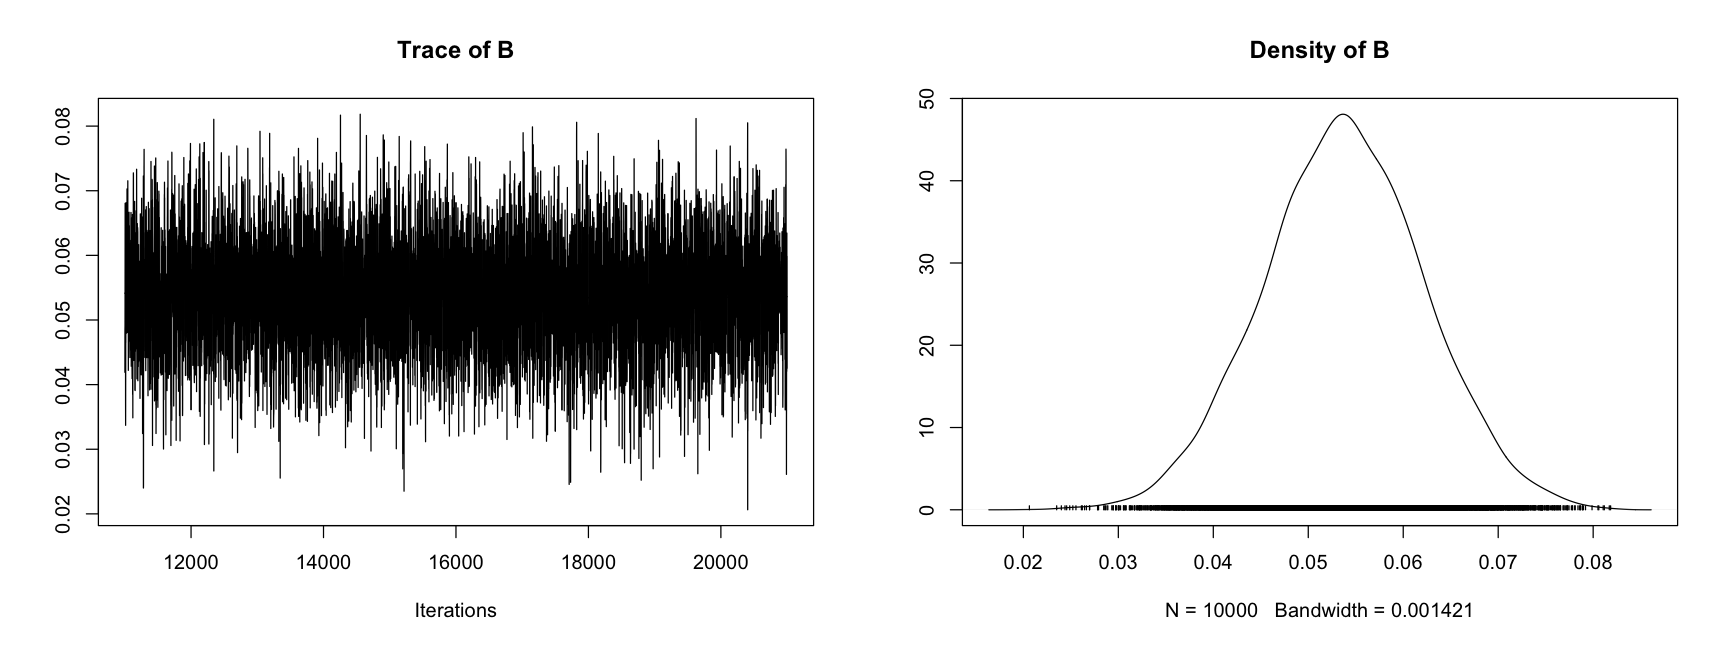

In [50]:
    # FIT OF THE REAL DATA WITH ONLYSAW


# Setting parameters for unif. priors
#B_0saw       <- 0.02
#max_Asaw     <- 0.00001
#width_Bsaw   <- 0.02
#max_phisaw   <- 0.0001
max_Aosaw     <- 0.05
max_Bosaw     <- 0.1
sc_B          <- 0.1
max_phiosaw   <- 2 * pi

modello_osaw    <-    "ONLYSAW.bug" # file con modello di puro segnale

#model_saw_init    <- list(A = 0.02, B = 0.01, phi = pi/4)
model_osaw_init    <- list(B = 0.01)


fitInput_r_osaw <- NULL

fitInput_r_osaw$n      <- N_r
fitInput_r_osaw$x      <- x_real
fitInput_r_osaw$sd     <- sd_real
fitInput_r_osaw$t      <- ren_t
fitInput_r_osaw$ft     <- time_resc
fitInput_r_osaw$v      <- 1
fitInput_r_osaw$pi     <- pi
    
# prior parameters
fitInput_r_osaw$max_A   <- max_Aosaw
fitInput_r_osaw$max_phi <- max_phiosaw
fitInput_r_osaw$max_B   <- max_Bosaw
fitInput_r_osaw$sc_B   <- sc_B

    
m_osaw_r <- jags.model(modello_osaw,
                    fitInput_r_osaw,
                    model_osaw_init
                   )

update(m_osaw_r, 10000)                  # burn in 

to.sample_osaw_r = c('B')

catena_osaw_r <- coda.samples(m_osaw_r, to.sample_osaw_r, n.iter=10000)  # sampling 
    
mcmc_osaw_r <- as.mcmc(catena_osaw_r)

print(summary(catena_osaw_r))

plot(catena_osaw_r)

In [51]:
# First rough extimations of odds factors

    l_cos_r <- 1
    for (j in 1:N_r) {
        l_cos_r <- l_cos_r * dnorm(x_real[j],
                                         mean = rate_sim(ren_t[j],time_resc[j],
                                                         SAW = 0,
                                                         A   = mean(mcmc_cos_r[,"A"]),
                                                         phi = phi_0                                                         
                                                        ),
                                         sd = sd_real[j])
    }
#    l_saw_r <- 1
#    for (j in 1:N_r) {
#        l_saw_r <- l_saw_r * dnorm(x_real[j],
#                                         mean = rate_sim(ren_t[j],
#                                                         SAW = 1,
#                                                         A   = mean(mcmc_saw_r[,"A"]),
#                                                         phi = mean(mcmc_saw_r[,"phi"]),
#                                                         B   = mean(mcmc_saw_r[,"B"])),
#                                         sd = sd_real[j])
#    }

    l_osaw_r <- 1
    for (j in 1:N_r) {
        l_osaw_r <- l_osaw_r * dnorm(x_real[j],
                                         mean = rate_sim(ren_t[j], time_resc[j],
                                                         SAW = 1,
                                                         A   = 0,
                                                         phi = phi_0,
                                                         B   = mean(mcmc_osaw_r[,"B"])),
                                         sd = sd_real[j])
    }
    
   
    
    ock_cos_r <- sqrt(2*pi)^(1)*sd(mcmc_cos_r[,"A"])*dgamma(mean(mcmc_cos_r[,"A"]),1,1/sc_A);
#    ock_cos_r <- sqrt(2*pi)^(1)*sd(mcmc_cos_r[,"A"])/max_Acos;

    
#    ock_saw_r <- sqrt(2*pi)^(3)*sd(mcmc_saw_r[,"A"])*
#                                   sd(mcmc_saw_r[,"B"])*
#                                   sd(mcmc_saw_r[,"phi"])/(max_Asaw * (2*width_Bsaw) * max_phisaw);

    
    ock_osaw_r <- sqrt(2*pi)^(1)*sd(mcmc_osaw_r[,"B"])/(max_Bosaw);
    
    
#    O12_r <- (l_cos_r * ock_cos_r)/(l_saw_r*ock_saw_r);
#    O21_r <- 1/O12_r

    
    O13_r <- (l_cos_r * ock_cos_r)/(l_osaw_r*ock_osaw_r);
    O31_r <- 1/O13_r

    
#    O32_r <- (l_osaw_r * ock_osaw_r)/(l_saw_r*ock_saw_r);
#    O23_r <- 1/O32_r

In [52]:
# Odds ratios for data generated from cos modulations
O13_r
O31_r

[1] 0.01438714

[1] 69.50652

In [53]:
ock_cos_r
ock_osaw_r
OC_CS = 10*log10(ock_cos_r/ock_osaw_r)
OC_CS

[1] 0.1037438

[1] 0.2129043

[1] -3.122224

In [54]:
log(l_cos_r)
log(l_osaw_r)
LR_CS = 10 * log10(l_cos_r/l_osaw_r)
LR_CS

[1] 105.8472

[1] 109.3697

[1] -15.29803

In [55]:
# Computing the CHI2

#tmpx = rate_sim(ren_t, SAW = 0,
#                    A   = mean(mcmc_cos_r[,"A"]),
#                    phi = mean(mcmc_cos_r[,"phi"])
#                   )
#sum((x_real - tmpx)^2 / ((sd_real)^2))
#tmpx = rate_sim(ren_t, SAW = 1,
#                    A   = mean(mcmc_saw_r[,"A"]),
#                    B   = mean(mcmc_saw_r[,"B"]),
#                    phi = mean(mcmc_saw_r[,"phi"])
#                   )
#sum((x_real - tmpx)^2 / ((sd_real)^2))

chi2_cos =- 2 * ( log(l_cos_r) - sum(log(1/(sqrt(2*pi*sd_real^2)))))
print(chi2_cos)
#chi2_saw =- 2 * ( log(l_saw_r) - sum(log(1/(sqrt(2*pi*sd_real^2)))))
#print(chi2_saw)
chi2_osaw =- 2 * ( log(l_osaw_r) - sum(log(1/(sqrt(2*pi*sd_real^2)))))
print(chi2_osaw)
print(N_r)

[1] 36.65225
[1] 29.60725
[1] 37


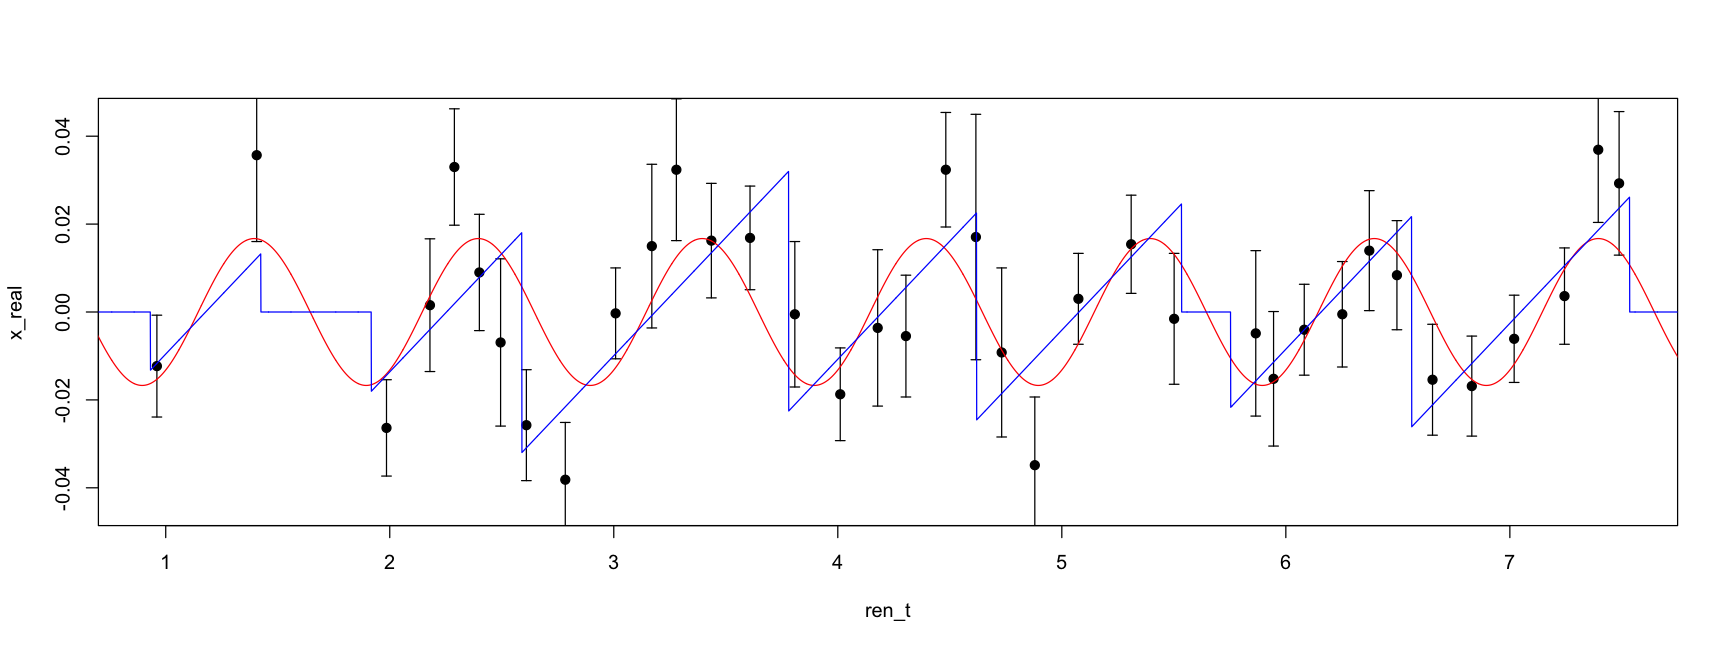

In [56]:
options(repr.plot.width=8*1.8, repr.plot.height=3*1.8)

plot(ren_t, x_real,
    pch=19, ylim = c(-1.5 * 0.03 , 1.5 * 0.03)
)
arrows(ren_t, x_real-sd_real, ren_t, x_real+sd_real, length=0.04, angle=90, code=3)

tmp <- seq(0., 8., by = 1e-3)
tr  <- seq(0., 8., by = 1e-3)

for (i in 1:length(tmp)) {
    tr[i] <- resc_t(tmp[i], timewindows)  
}

vec_cos <- rate_sim(x = tmp, rx= tr, SAW = 0,
                    A   = mean(mcmc_cos_r[,"A"]),
                    phi = 3.801730
                   )

vec_osaw <- rate_sim(x = tmp, rx= tr, SAW = 1,
                    A   = 0,
                    phi = 0,
                    B   = mean(mcmc_osaw_r[,"B"])
                   )

lines(tmp, vec_cos, col = 'red')
lines(tmp, vec_osaw,col= 'blue')


#lines(tmp, rate_sim(tmp, SAW = 0,
#                    A   = mean(mcmc_cos_r[,"A"]),
#                    phi = mean(mcmc_cos_r[,"phi"])
#                   ), col = 'red')
#lines(tmp, rate_sim(tmp, SAW = 1,
#                    A   = mean(mcmc_saw_r[,"A"]),
#                    phi = mean(mcmc_saw_r[,"phi"]),
#                    B   = mean(mcmc_saw_r[,"B"])
#                   ), col = 'blue')
#lines(tmp, rate_sim(tmp, SAW = 1,
#                    A   = 0,
#                    phi = 0,
#                    B   = mean(mcmc_osaw_r[,"B"])
#                   ), col = 'green')
#tmp2 <- 0*tmp
#lines(tmp, tmp2, col= 'green')

In [57]:
library(bridgesampling)
library(R2jags)
library(mcmcplots)

In [58]:
### functions for evaluating the unnormalized posteriors on log scale ###


log_posterior_cos <- function(pars, data) {
      
      
  A   <- pars["A"]
#  phi <- pars["phi"]

    
  sig <- A * cos(2. * pi * data$t / data$v + data$phi )


  out <-
      dgamma(A, 1, 1/data$sc_A, log = TRUE) + 
#      dunif(A, 0.0, data$max_A, log = TRUE) +          # prior
#      dunif(phi, 0.0, data$max_phi, log = TRUE) +      # prior
      sum(dnorm(data$x, sig, data$sd, log = TRUE))       # likelihood

 return(out)  
}



In [59]:
### functions for evaluating the unnormalized posteriors on log scale ###


#log_posterior_saw <- function(pars, data) {
      
      
#  A   <- pars["A"]
#  B   <- pars["B"]
#  phi <- pars["phi"]

    
#  sig <- A * cos(2. * pi * data$t / data$v + phi )
#  bkg <- -(B*data$v)/2. + B * ((data$t+0.15) %% data$v)

#    out <-
#      dunif(A, 0.0, data$max_A, log = TRUE) +          # prior
#      dunif(B, data$B_0 - data$width_B, data$B_0 + data$width_B, log = TRUE) +          # prior
#      dunif(phi, 0.0, data$max_phi, log = TRUE) +      # prior
#      sum(dnorm(data$x, sig+bkg, data$sd, log = TRUE))       # likelihood

# return(out)  
#}

In [60]:
### functions for evaluating the unnormalized posteriors on log scale ###


log_posterior_osaw <- function(pars, data) {
      
      
  B   <- pars["B"]

    
  bkg <-  B * (data$ft)

    out <-
      dunif(B, 0., 0.+ data$max_B, log = TRUE) +          # prior
      sum(dnorm(data$x, bkg, data$sd, log = TRUE))       # likelihood

 return(out)  
}

In [61]:
# specify parameter bounds for cos
#cn <- c("A", "phi")
cn <- c('A')
lb_cos <- rep(0, length(cn))
ub_cos <- rep(0, length(cn))
names(lb_cos) <- names(ub_cos) <- cn
#lb_cos["phi"] = 0.0
#ub_cos["phi"] = fitInput_r_cos$max_phi
lb_cos["A"] = 0.0 
ub_cos["A"] = fitInput_r_cos$sc_A
#ub_cos["A"] = fitInput_r_cos$max_A



In [62]:
# specify parameter bounds for cos
#cn <- c("A", "B", "phi")
#lb_saw <- rep(0, length(cn))
#ub_saw <- rep(0, length(cn))
#names(lb_saw) <- names(ub_saw) <- cn
#lb_saw["phi"] = 0.0
#ub_saw["phi"] = fitInput_r_saw$max_phi
#lb_saw["A"] = 0.0 
#ub_saw["A"] = fitInput_r_saw$max_A
#lb_saw["B"] = fitInput_r_saw$B_0 - fitInput_r_saw$width_B 
#ub_saw["B"] = fitInput_r_saw$B_0 + fitInput_r_saw$width_B 


In [63]:
# specify parameter bounds for cos
cn <- c("B")
lb_osaw <- rep(0, length(cn))
ub_osaw <- rep(0, length(cn))
names(lb_osaw) <- names(ub_osaw) <- cn
lb_osaw["B"] = 0. 
ub_osaw["B"] = 0. + fitInput_r_osaw$max_B 


In [64]:
# compute log marginal likelihood via bridge sampling for H0
cos.bridge <- bridge_sampler(samples = catena_cos_r, data = fitInput_r_cos,
                            log_posterior = log_posterior_cos, lb = lb_cos,
                            ub = ub_cos, silent = TRUE, verbose = TRUE, maxiter = 300)

[1] "summary(q12): (log_dens of proposal (i.e., with dmvnorm) for posterior samples)"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-5.7903  0.2343  0.6736  0.3949  0.8558  0.9087 
[1] "summary(q22): (log_dens of proposal (i.e., with dmvnorm) for generated samples)"
[[1]]
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-5.4233  0.2815  0.6969  0.4342  0.8617  0.9087 

[1] "summary(q11): (log_dens of posterior (i.e., with log_posterior) for posterior samples)"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  97.81  103.80  104.26  103.98  104.45  104.50 
[1] "summary(q21): (log_dens of posterior (i.e., with log_posterior) for generated samples)"
[[1]]
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  97.28  103.85  104.28  104.01  104.45  104.50 



In [65]:
# compute log marginal likelihood via bridge sampling for H0
#saw.bridge <- bridge_sampler(samples = catena_saw_r, data = fitInput_r_saw,
#                            log_posterior = log_posterior_saw, lb = lb_saw,
#                            ub = ub_saw, silent = TRUE, verbose = TRUE, maxiter = 300)

In [66]:
# compute log marginal likelihood via bridge sampling for H0
osaw.bridge <- bridge_sampler(samples = catena_osaw_r, data = fitInput_r_osaw,
                            log_posterior = log_posterior_osaw, lb = lb_osaw,
                            ub = ub_osaw, silent = TRUE, verbose = TRUE, maxiter = 300)

[1] "summary(q12): (log_dens of proposal (i.e., with dmvnorm) for posterior samples)"
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-8.09663 -0.03043  0.38545  0.10814  0.54308  0.58645 
[1] "summary(q22): (log_dens of proposal (i.e., with dmvnorm) for generated samples)"
[[1]]
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-7.99782 -0.05251  0.36725  0.09250  0.54067  0.58645 

[1] "summary(q11): (log_dens of posterior (i.e., with log_posterior) for posterior samples)"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  100.4   107.7   108.2   107.9   108.4   108.4 
[1] "summary(q21): (log_dens of posterior (i.e., with log_posterior) for generated samples)"
[[1]]
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  100.5   107.7   108.2   107.9   108.4   108.4 



In [67]:
print(osaw.bridge)

Bridge sampling estimate of the log marginal likelihood: 107.8148
Estimate obtained in 4 iteration(s) via method "normal".


In [68]:
error_measures(osaw.bridge)

$re2
[1] 3.134244e-07

$cv
[1] 0.0005598432

$percentage
[1] "0%"

In [69]:
print(cos.bridge)

Bridge sampling estimate of the log marginal likelihood: 103.5826
Estimate obtained in 4 iteration(s) via method "normal".


In [70]:
error_measures(cos.bridge)

$re2
[1] 2.535894e-07

$cv
[1] 0.0005035766

$percentage
[1] "0%"

In [71]:
BF01 <- bf(cos.bridge, osaw.bridge)
print(BF01)

Estimated Bayes factor in favor of cos.bridge over osaw.bridge: 0.01452


In [72]:
BF01$log

[1] FALSE

In [73]:
post <- post_prob(cos.bridge, osaw.bridge)
print(post)

 cos.bridge osaw.bridge 
 0.01431224  0.98568776 


In [74]:
10 *log10(0.27985)

[1] -5.530747

In [75]:
results$A_mean = mean(mcmc_cos_r[,"A"])    
results$A_sd   = sd(mcmc_cos_r[,"A"])
results$B_mean = mean(mcmc_osaw_r[,"B"])     
results$B_sd   = sd(mcmc_osaw_r[,"B"])
results$LR_CS  = LR_CS     
results$OC_CS  = OC_CS
results$BF_CS  = log10(BF01$bf)*10
results$chi2_C = chi2_cos     
results$chi2_S = chi2_osaw     
results$dof    = N_r - 1



In [76]:
results$BF_CS

[1] -18.38032

In [77]:
LR_CS + OC_CS

[1] -18.42026

In [78]:
OC_CS

[1] -3.122224

In [79]:
LR_CS

[1] -15.29803

In [80]:
(103.3-105.5)*10/log(10)

[1] -9.554479

In [81]:
results

$A_mean
[1] 0.01670907

$A_sd
[1] 0.002890515

$B_mean
[1] 0.05374297

$B_sd
[1] 0.008493652

$chi2_C
[1] 36.65225

$chi2_S
[1] 29.60725

$LR_CS
[1] -15.29803

$OC_CS
[1] -3.122224

$BF_CS
[1] -18.38032

$dof
[1] 36

In [82]:
(10^(results$OC_CS/10))

[1] 0.4872789